# Quantum Machine Learning (QLSTM-DEMO)
#### Using Quantum Long Short-Term Memory (QLSTM) for Time Series Prediction

Lead authors: <br>
Dr. Stefan Kister and Jonas Michel<br>

Created initially by Dr. Stefan Kister (IBM Quantum Ambassador, IBM DACH) and Jonas Michel (jonas.michel@ibm.com, Corporate Student, IBM DACH): July 2023<br>


## Table of Contents

1. [Machine Learning Introduction](#1.-machine-learning-introduction)
2. [Long Short-Term Memory Overview](#2.-long-short-term-memory-overview)
    1. [Workflow](#2.1.-workflow)
    2. [Architecture](#2.2.-architecture)
    3. [Applications of LSTM's](#2.3.-applications-of-LSTM's)
3. [Practical LSTM Demonstration **[CLASSIC]**](#3.-practical-lstm-demonstration-CLASSIC)
4. [QLSTM Theory](#4.-qlstm-theory)
    1. [Quantum Machine Learning with Qiskit](#41-quantum-machine-learning-with-qiskit)
    2. [Quantum Workflow](#42-quantum-workflow)
    3. [Quantum Architecture](#43-quantum-architecture)
5. [Practical QLSTM Demonstration **[QUANTUM]**](#5.-practical-qlstm-demonstration-QUANTUM)
6. [Summary](#6.-summary)
    1. [Results](#6.1.-results)
    2. [Architecture Comparison](#6.2.-architecture-comparison)

### Imports & Parameters

In [2]:
### IMPORTS ###

import math
import torch
import torch.nn as nn
import torchmetrics

from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# utils/data_processing.py with processing functions
import utils.data_processing as dp

# utils/reproducibility.py with reproducibility functions
import utils.reproducibility as repo

In [3]:
### PARAMETERS ###

# data parameters
DATA_PATH = "data/data_damped_oscillator.csv"
TIME_SEQUENCE = 4

# model parameters:
"""is the size of the input feature dimension, in our case with functions always 1"""
INPUT_SIZE = 1
"""  HIDDEN_DIMENSION = hidden_size, dimension of the hidden state, represents the size or dimensionality of the hidden state in the LSTM """
HIDDEN_DIMENSION = 4

# training parameters:
NUM_EPOCHS = 50
TRAIN_TEST_SPLIT = 0.67
BATCH_SIZE = 16
LEARNING_RATE = 0.01

REPS = 1

# random seed for reproducibility
SEED = 1

<br>

## 1. Machine Learning Introduction

<div>
<img src="./data/images/1_ml_paradigms.png" width="1000"/>
</div>

<div>
<img src="./data/images/2_problem-types.png" width="1000"/>
</div>

## 2. Long Short-Term Memory Overview

### 2.1 Workflow

<div>
<img src="images/ml-workflow.png" width="1000"/>
</div>

### 2.2 Network Architecture

<div>
<img src="images/classic-architecture.png" width="800"/>
</div>


<b><u>Gate and Cell Formulas:</b></u>

Forget Gate: 
$f(t) = σ(W_f * [h(t-1), x(t)] + b_f)$
- determines what information from the previous cell state C(t-1) should be discarded

<br>

Input Gate:
$i(t) = σ(W_i * [h(t-1), x(t)] + b_i)$
- controls which values from the input x(t) and the previous cell state C(t-1) should be updated.

<br>

Candidate Cell State:
$C~(t) = tanh(W_c * [h(t-1), x(t)] + b_c)$
- based on the input x(t) and the previous hidden state h(t-1)

<br>

Update Cell State:
$C(t) = f(t) * C(t-1) + i(t) * C~(t)$
- is based on the forget gate, input gate, and candidate cell state

<br>

Output Gate:
$o(t) = σ(W_o * [h(t-1), x(t)] + b_o)$
- determines the next hidden state h(t) based on the current cell state 

<br>

Final Hidden State: 
$h(t) = o(t) * tanh(C(t))$
- based on the cell state and the output gate

Pytorch Implementation:

In [4]:
class LongShortTermMemory(nn.Module):
    def __init__(self, input_size: int=1, hidden_size: int=4, seed: int=1):
        """ Initializes custom build LSTM model.

        Parameters:
            input_size (int): The dimensionality of the input for the LSTM (input feature).
            hidden_sz (int): The number of hidden units in the LSTM (dimensionality of the hidden state).
        """
        super().__init__()

        self.input_sz = input_size
        self.hidden_sz = hidden_size
        self.seed = seed

        # weight matrix W - input gate
        self.W = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        # weight matrix U - forget gate
        self.U = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))
        # call the init weights function
        self.init_weights()

        # output layer
        self.linear = nn.Linear(hidden_size, 1)
                
    def init_weights(self):
        """ initialize weights with random uniform distribution """
        stdv = 1.0 / math.sqrt(self.hidden_sz)
        matrix_count = 0
        for weight in self.parameters():
            # set seed for reproducibility, add matrix_count to seed to get different seeds for each matrix (W, U, bias)
            repo.set_seed(self.seed + matrix_count)
            weight.data.uniform_(-stdv, stdv)
            matrix_count += 1
         
    def forward(self, x: torch.Tensor, memory_states: tuple = None):
        # necessary: x is of shape (batch_size, sequence_window, feature)
        bs, seq_sz, _ = x.size()
        outputs = []
        if memory_states is None:
            # initialize memory states
            h_t, c_t = (torch.zeros(bs, self.hidden_sz).to(x.device), 
                        torch.zeros(bs, self.hidden_sz).to(x.device))
        else:
            h_t, c_t = memory_states
        
        HS = self.hidden_sz
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            ## compute the gates (standard way)
            # i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            # f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            # g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            # o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)

            ## more effective is to batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            y_t = self.linear(h_t)
            outputs.append(h_t.unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        outputs = outputs.transpose(0, 1).contiguous()

        # return the last state of the hidden state sequence
        return  y_t, (h_t, c_t)

### 2.3 Applications of LSTM's

1. **Language modeling** character and word level LSTM’s are used
(TensorFlow tutorial on PTB https://github.com/abreheret/tensorflow-models/blob/master/tutorials/rnn/ptb/ptb_word_lm.py) 

2. **Machine Translation** also known as sequence to sequence learning (https://arxiv.org/pdf/1409.3215.pdf)

3. **Image captioning** (with and without attention, https://arxiv.org/pdf/1411.4555v2.pdf)

4. **Hand writing generation** (http://arxiv.org/pdf/1308.0850v5.pdf)

5. **Image generation** using attention models (https://arxiv.org/pdf/1502.04623v2.pdf)

6. **Question answering** (http://www.aclweb.org/anthology/P15-2116)

7. **Video to text** (https://arxiv.org/pdf/1505.00487v3.pdf)

8. Demo usecase: **Time Series Prediction**

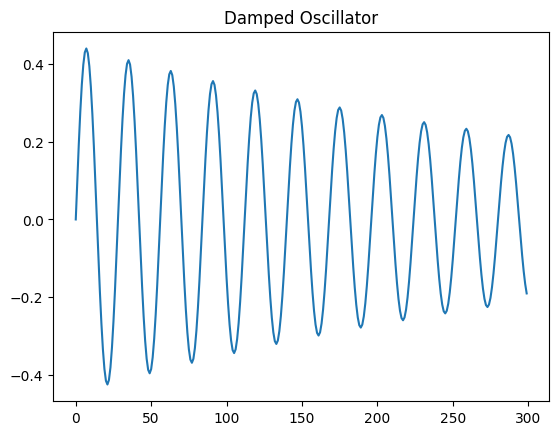

In [5]:
# data loading
data = pd.read_csv(DATA_PATH, usecols=["y"])
plt.title("Damped Oscillator")
plt.plot(data);

In this demo case, a damped oscillator is used. The data used is generated in data/data_damped_oscillator.ipynb

This dataset is intended for use in time series forecasting. To achieve this, the data needs to be prepared and transformed into the correct format. Specifically, the first approximately 200 data points should be used for training, and the last 100 data points should be used for testing.

## 3. Practical LSTM Demonstration **[CLASSIC]**

#### Data Preparation

<div>
<img src="images/data_prep.png" width="600"/>
</div>

The shape of the input and target tensors depend on the number of time steps and the machine learning step. For the training we are going to use a batch size of 32. The input tensor has the shape (batch size, time steps)

The following function creates a time_series matrix and target array and splits these into training and test sets for sequence prediction tasks.

In [6]:
# preprocess and split data - data_processing() from data_processing.py
input_train, target_train, input_test, target_test = dp.data_processing(data, time_sequence=TIME_SEQUENCE, train_test_split=TRAIN_TEST_SPLIT, reshape_inputs=True)

All shapes are correct.


To gain a deeper understanding of the preprocessing it is worth taking a look at the outputs.

In [7]:
# first 7 values of the initial dataset
torch.from_numpy(data.values[0:7])

tensor([[0.0000],
        [0.0992],
        [0.1931],
        [0.2767],
        [0.3461],
        [0.3979],
        [0.4296]], dtype=torch.float64)

In [8]:
# input matrix (train set) - first values
input_train[0]

tensor([[0.0000],
        [0.0992],
        [0.1931],
        [0.2767]])

In [9]:
# target matrix (train set) - first value (the value which should be predicted, by the previous values)
target_train[0]

tensor([[0.3461]])

The next steps connect input and target data to a Pytorch Dataset.

The dataset is then given to a PyTorch DataLoader which will be used to create batches of data for the LSTM.

In [10]:
# create a TensorDataset from input and target tensors
train_dataset = torch.utils.data.TensorDataset(input_train, target_train)

# create a DataLoader for efficient batch processing
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=repo.seed_worker, generator=torch.Generator().manual_seed(SEED))

#### Initialize and Train LSTM

The model will be trained classically using PyTorch. PyTorch hat Qiskit implementation 

<div>
<img src="images/train.png" width="750"/>
</div>

In [11]:
# initialize the model
lstm = LongShortTermMemory(input_size=INPUT_SIZE, hidden_size=HIDDEN_DIMENSION, seed=SEED)

# initialize the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

# set the model to training mode
lstm.train() 

# training loop
losses = []
for epoch in range(NUM_EPOCHS):
    # clear gradients them out before each instance
    lstm.zero_grad()

    running_loss = 0.0
    for batch_input, batch_target in data_loader:
        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output , (_, _) = lstm(batch_input)
        # compute the loss
        loss = loss_function(output, batch_target.reshape(len(batch_target), 1))

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # accumulate the loss
        running_loss += loss.item()

    # compute the average loss for the epoch
    epoch_loss = running_loss / len(data_loader)

    # save loss for plotting
    losses.append(epoch_loss)

    # Print the loss for the epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.6f}")

Epoch [1/50], Loss: 0.072796
Epoch [2/50], Loss: 0.047798
Epoch [3/50], Loss: 0.036186
Epoch [4/50], Loss: 0.022019
Epoch [5/50], Loss: 0.014410
Epoch [6/50], Loss: 0.013542
Epoch [7/50], Loss: 0.012393
Epoch [8/50], Loss: 0.011646
Epoch [9/50], Loss: 0.010879
Epoch [10/50], Loss: 0.010101
Epoch [11/50], Loss: 0.009345
Epoch [12/50], Loss: 0.008601
Epoch [13/50], Loss: 0.007875
Epoch [14/50], Loss: 0.007171
Epoch [15/50], Loss: 0.006495
Epoch [16/50], Loss: 0.005853
Epoch [17/50], Loss: 0.005245
Epoch [18/50], Loss: 0.004672
Epoch [19/50], Loss: 0.004134
Epoch [20/50], Loss: 0.003628
Epoch [21/50], Loss: 0.003147
Epoch [22/50], Loss: 0.002688
Epoch [23/50], Loss: 0.002246
Epoch [24/50], Loss: 0.001821
Epoch [25/50], Loss: 0.001418
Epoch [26/50], Loss: 0.001049
Epoch [27/50], Loss: 0.000731
Epoch [28/50], Loss: 0.000481
Epoch [29/50], Loss: 0.000305
Epoch [30/50], Loss: 0.000200
Epoch [31/50], Loss: 0.000146
Epoch [32/50], Loss: 0.000123
Epoch [33/50], Loss: 0.000112
Epoch [34/50], Loss

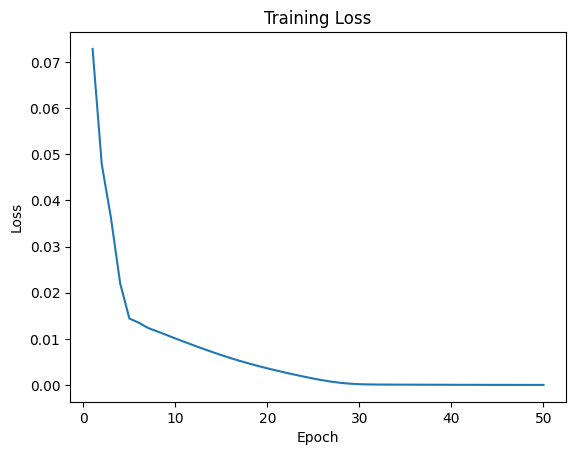

In [12]:
# Plot the loss over epochs
plt.plot(range(1, NUM_EPOCHS+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss');

Here we can see the average loss after every epoch of training.

### Evaluate the Model

In [13]:
# reshape the the target(_test & _train) tensor [len, 1, 1] - to match the shape of the pred tensor [len, 1]
target_test_reshape = target_test.reshape(len(target_test), 1)
target_train_reshape = target_train.reshape(len(target_train), 1)

<div>
<img src="images/model_eva.png" width="600"/>
</div>

In [14]:
# set the model to evaluation mode
lstm.eval()  

# predict the test set
with torch.no_grad():
    ### prediction for the test set
    pred_test, (_, _) = lstm(input_test)

    # calculate errors
    mean_squared_error = nn.MSELoss()
    mse_test = mean_squared_error(pred_test, target_test_reshape)

    mean_abs_error = torchmetrics.MeanAbsoluteError()
    mae_test = mean_abs_error(pred_test, target_test_reshape)

    ### prediction for the train set
    pred_train, (_, _) = lstm(input_train)

    mean_squared_error = nn.MSELoss()
    mse_train = mean_squared_error(pred_train, target_train_reshape)

    mean_abs_error = torchmetrics.MeanAbsoluteError()
    mae_train = mean_abs_error(pred_train, target_train_reshape)

print(f"MSE on TRAIN set:\t{mse_train:.5f} \t(Mean Squared Error)")
print(f"MSE on TEST set:\t{mse_test:.5f} \t(Mean Squared Error)")

print(f"\nMAE on TRAIN set:\t{mae_train:.5f} \t(Mean Absolute Error)")
print(f"MAE on TEST set:\t{mae_test:.5f} \t(Mean Absolute Error)")

MSE on TRAIN set:	0.00004 	(Mean Squared Error)
MSE on TEST set:	0.00001 	(Mean Squared Error)

MAE on TRAIN set:	0.00522 	(Mean Absolute Error)
MAE on TEST set:	0.00270 	(Mean Absolute Error)


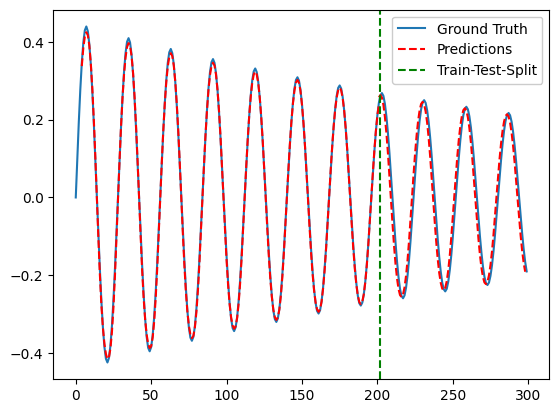

In [15]:
# shift data for correct plotting
train_predict_plot, test_predict_plot = dp.shift_train_test_predict(data, pred_train, pred_test, TIME_SEQUENCE)

# plot baseline and predictions
plt.plot(data, label="Ground Truth")
plt.plot(train_predict_plot, "r--", label='Predictions')
plt.plot(test_predict_plot, "r--")
# plot line to show train-test-split
plt.axvline(x=TIME_SEQUENCE+len(pred_train), color='g', linestyle='--', label="Train-Test-Split")
plt.legend(framealpha=1, frameon=True)
plt.show()

## 4. QLSTM Theory

### 4.1 Quantum Machine Learning with Qiskit

<div>
<img src="images/qiskit_2.svg" width="1000"/>
</div>

<div>
<img src="images/qiskit_1.png" width="1000"/>
</div>

### 4.2 Quantum Workflow

<div>
<img src="images/ml-workflow-quantum.png" width="1000"/>
</div>

The classic LSTM gate structure is replaced with quantum layers.

The quantum layers are formed by two circuit parts. The data encoding and the variational layer, which can be optimized.

<div>
<img src="images/new.png" width="1000"/>
</div>


The Feature Map is used for data encoding. This circuit part maps the input data to a quantum state. 

The Variational Layer is a layer that contains the trainable parameters of the circuit.

The output of the circuit is the tensor products of 4. It is the expectation value of a Hamiltonian (in our case the Pauli Z operator), which is a real number between -1 and 1. 

In [16]:
class DataEncoding(QuantumCircuit):
    """
    Feature Map for Quantum LSTM from: 
    https://arxiv.org/pdf/2009.01783.pdf
    """
    def __init__(self, qbits=4, name="data-encoding"):
        super().__init__(qbits, name=name)
        # input parameters
        x_input = ParameterVector('x', length=4)
        
        # encoding
        for i in range(4):
            self.h(i)
            self.ry(x_input[i].arctan(), i)
            self.rz((x_input[i]*x_input[i]).arctan(), i)


class VariationalLayer(QuantumCircuit):
    """
    Variational Layer for Quantum LSTM from: 
    https://arxiv.org/pdf/2009.01783.pdf
    """
    def __init__(self, qbits=4, name="variational-layer"):
        super().__init__(qbits, name=name)
        # weight parameters
        alpha = ParameterVector('α', length=4)
        beta = ParameterVector('β', length=4)
        gamma = ParameterVector('γ', length=4)

        # entanglement
        self.cx(0,1)
        self.cx(1,2)
        self.cx(2,3)
        self.cx(3,0)
        self.cx(0,2)
        self.cx(1,3)
        self.cx(2,0)
        self.cx(3,1)

        # x,y,z rotation
        for i in range(4):
            self.rx(alpha[i], i)
            self.ry(beta[i], i)
            self.rz(gamma[i], i)

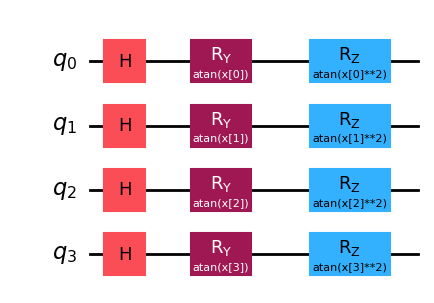

In [17]:
feature_map = DataEncoding()
feature_map.draw("mpl")

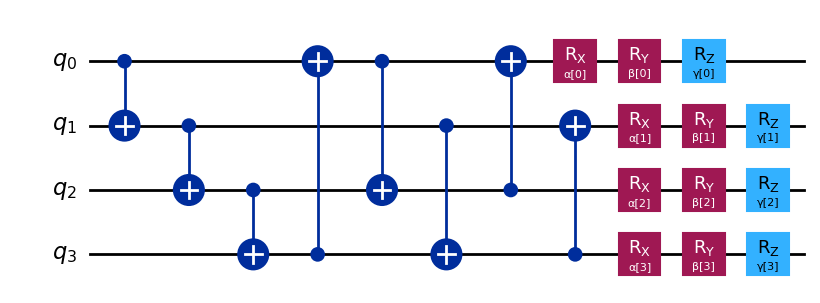

In [18]:
ansatz = VariationalLayer()
ansatz.draw("mpl")

VQC

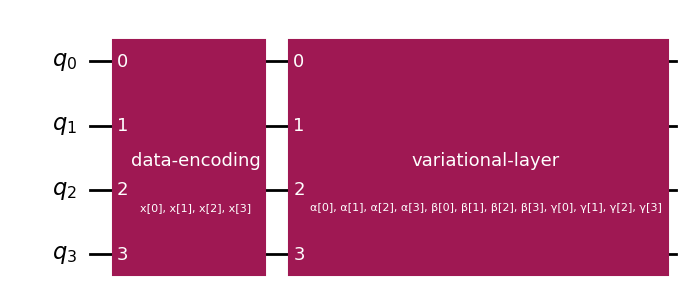

In [19]:
qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
for _ in range(1):
    qc.append(ansatz, range(4))

qc.draw("mpl")

### 4.3 Quantum Architecture

<div>
<img src="images/quantum-architecture.png" width="800"/>
</div>

Here we can see how the quantum layers are embedded into the LSTM cell.

In [20]:
class QuantumLongShortTermMemory(nn.Module):
    def __init__(self, feature_map, ansatz, reps, input_size: int=4, hidden_size: int=1, seed: int=1):
        super().__init__()
        num_qbits = 4

        self.input_sz = input_size
        self.hidden_sz = hidden_size
        self.seed = seed

        # construct quantum layer
        self.VQC = nn.ModuleDict() # WICHTIG to connect 
        self.construct_VQC_layer(num_qbits, feature_map, ansatz, reps)

        # classical layer
        self.input_layer = nn.Linear(self.input_sz + self.hidden_sz, self.input_sz)
        self.input_layer_2 = nn.Linear(1, self.input_sz)


    def construct_VQC_layer(self, qbits, feature_map, ansatz, reps):
        # construct the 4 QNN layer
        for layer_name in ["1", "2", "3", "4", "5"]:
            # construct the quantum circuit
            qc = QuantumCircuit(qbits)
            # append the feature map and ansatz (with reps) to the circuit
            qc.append(feature_map, range(qbits))
            for _ in range(reps):
                qc.append(ansatz, range(qbits))

            # initialize the QNN layer
            obsv = SparsePauliOp(["ZZZZ"]) 
            
            estimator = EstimatorQNN(
                    circuit=qc,
                    observables=obsv,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    input_gradients=True
            )

            # WICHTIG connector
            self.VQC[layer_name] = TorchConnector(estimator)


    def forward(self, X: torch.Tensor, memory_states: tuple = None):
        if memory_states is None:
            # initialize memory states
            h_t, c_t = (torch.zeros(1, self.hidden_sz).to(X.device), 
                        torch.zeros(1, self.hidden_sz).to(X.device))
        else:
            h_t, c_t = memory_states 

        outputs = []
        for sample_x in X: 
            v_t = torch.cat([sample_x, h_t], dim=0)
            v_t_input = self.input_layer(v_t.reshape(1, -1)).reshape(-1)
            # QNN layer
            f_t = torch.sigmoid(self.VQC["1"](v_t_input))
            i_t = torch.sigmoid(self.VQC["2"](v_t_input))
            c_tilde = torch.tanh(self.VQC["3"](v_t_input))
            c_t = f_t * c_t + i_t * c_tilde
            o_t = torch.sigmoid(self.VQC["4"](v_t_input))
            h_t = self.VQC["5"]((self.input_layer_2(o_t * torch.tanh(c_t))))
            outputs.append(h_t.unsqueeze(0))
        
        outputs = torch.cat(outputs, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        outputs = outputs.transpose(0, 1).contiguous()

        return outputs, (h_t, c_t)

## 5. Practical QLSTM Demonstration **[QUANTUM]**

### QLSTM-Model Training

In [21]:
# initialize the model
q_lstm = QuantumLongShortTermMemory(feature_map=feature_map, ansatz=ansatz, reps=2)

# initialize the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(q_lstm.parameters(), lr=LEARNING_RATE)

# set the model to training mode
q_lstm.train() 

# training loop
losses = []

# get the number of batches to process
if len(train_dataset) % BATCH_SIZE == 0:
    num_batches = len(train_dataset) // BATCH_SIZE
else:
    num_batches = len(train_dataset) // BATCH_SIZE + 1

for epoch in range(NUM_EPOCHS):
    # clear gradients them out before each instance
    q_lstm.zero_grad()

    running_loss = 0.0
    batch_num = 1
    for batch_input, batch_target in data_loader:
        print(f"\rEpoch [{epoch+1}/{NUM_EPOCHS}]: Batch Number [{batch_num}/{num_batches}]", end="", flush=True)
        batch_num += 1
        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        outputs , (_, _) = q_lstm(batch_input)

        # compute the loss
        loss = loss_function(outputs.reshape(len(batch_input), 1), batch_target.reshape(len(batch_target), 1))

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # accumulate the loss
        running_loss += loss.item()
    
    # compute the average loss for the epoch
    epoch_loss = running_loss / len(data_loader)

    # save loss for plotting
    losses.append(epoch_loss)

    # Print the loss for the epoch
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]; Loss: {epoch_loss:.6f}\n")

Epoch [1/50]: Batch Number [1/13]

Epoch [1/50]: Batch Number [13/13]
Epoch [1/50]; Loss: 0.059696

Epoch [2/50]: Batch Number [13/13]
Epoch [2/50]; Loss: 0.050356

Epoch [3/50]: Batch Number [13/13]
Epoch [3/50]; Loss: 0.037336

Epoch [4/50]: Batch Number [13/13]
Epoch [4/50]; Loss: 0.025593

Epoch [5/50]: Batch Number [13/13]
Epoch [5/50]; Loss: 0.015836

Epoch [6/50]: Batch Number [13/13]
Epoch [6/50]; Loss: 0.008561

Epoch [7/50]: Batch Number [13/13]
Epoch [7/50]; Loss: 0.003622

Epoch [8/50]: Batch Number [13/13]
Epoch [8/50]; Loss: 0.001262

Epoch [9/50]: Batch Number [13/13]
Epoch [9/50]; Loss: 0.000744

Epoch [10/50]: Batch Number [13/13]
Epoch [10/50]; Loss: 0.000570

Epoch [11/50]: Batch Number [13/13]
Epoch [11/50]; Loss: 0.000451

Epoch [12/50]: Batch Number [13/13]
Epoch [12/50]; Loss: 0.000408

Epoch [13/50]: Batch Number [13/13]
Epoch [13/50]; Loss: 0.000368

Epoch [14/50]: Batch Number [13/13]
Epoch [14/50]; Loss: 0.000332

Epoch [15/50]: Batch Number [13/13]
Epoch [15/50]; Loss: 0.000301

Epoch [16/50]

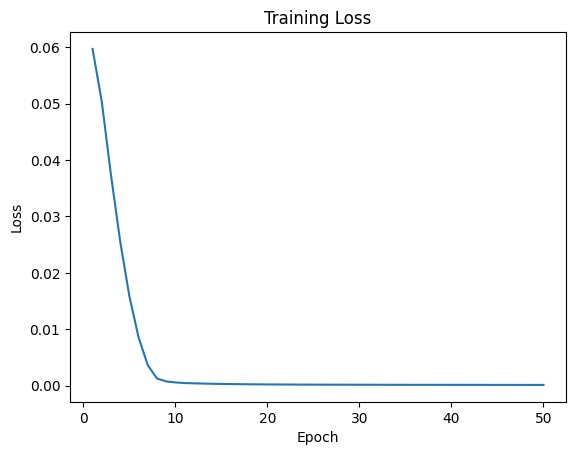

In [41]:
# Plot the loss over epochs
plt.plot(range(1, NUM_EPOCHS+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss');

### QLSTM-Model Evaluation

In [42]:
# set the model to evaluation mode
q_lstm.eval()  

# predict the test set
with torch.no_grad():
    ### prediction for the test set
    pred_test_q, (_, _) = q_lstm(input_test)
    # calculate errors
    pred_test_q = pred_test_q.reshape(len(target_test_reshape), 1)

    mean_squared_error = nn.MSELoss()
    mse_test = mean_squared_error(pred_test_q, target_test_reshape)

    mean_abs_error = torchmetrics.MeanAbsoluteError()
    mae_test = mean_abs_error(pred_test_q, target_test_reshape)

    ### prediction for the train set
    pred_train_q, (_, _) = q_lstm(input_train)

    mean_squared_error = nn.MSELoss()
    pred_train_q = pred_train_q.reshape(len(target_train_reshape), 1)
    mse_train = mean_squared_error(pred_train_q, target_train_reshape)

    mean_abs_error = torchmetrics.MeanAbsoluteError()
    mae_train = mean_abs_error(pred_train_q, target_train_reshape)

print(f"MSE on TRAIN set:\t{mse_train:.5f} \t(Mean Squared Error)")
print(f"MSE on TEST set:\t{mse_test:.5f} \t(Mean Squared Error)")

print(f"\nMAE on TRAIN set:\t{mae_train:.5f} \t(Mean Absolute Error)")
print(f"MAE on TEST set:\t{mae_test:.5f} \t(Mean Absolute Error)")

MSE on TRAIN set:	0.00007 	(Mean Squared Error)
MSE on TEST set:	0.00002 	(Mean Squared Error)

MAE on TRAIN set:	0.00622 	(Mean Absolute Error)
MAE on TEST set:	0.00344 	(Mean Absolute Error)


In the next step, we are going to shift the data correctly, so that we can plot them. This means we append the pred_test to the pred_train.

In [43]:
# shift data for correct plotting
train_predict_plot, test_predict_plot = dp.shift_train_test_predict(data, pred_train_q, pred_test_q, TIME_SEQUENCE)

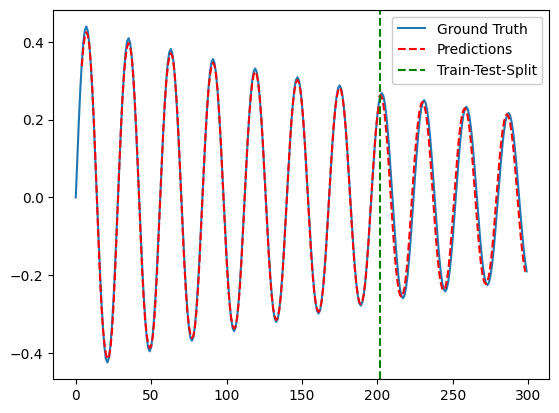

In [44]:
# shift data for correct plotting
train_predict_plot_q, test_predict_plot_q = dp.shift_train_test_predict(data, pred_train, pred_test, TIME_SEQUENCE)

# plot baseline and predictions
plt.plot(data, label="Ground Truth")
plt.plot(train_predict_plot_q, "r--", label='Predictions')
plt.plot(test_predict_plot_q, "r--")
# plot line to show train-test-split
plt.axvline(x=TIME_SEQUENCE+len(pred_train), color='g', linestyle='--', label="Train-Test-Split")
plt.legend(framealpha=1, frameon=True)
plt.show()

## 6. Summary

### 6.1 Results

In [45]:
print("Number of QLSTM parameters: ", sum(p.numel() for p in q_lstm.parameters() if p.requires_grad))

print("\nNumber of LSTM parameters: ", sum(p.numel() for p in lstm.parameters() if p.requires_grad))


Number of QLSTM parameters:  92

Number of LSTM parameters:  101


The number of trained parameter is roughly the same.

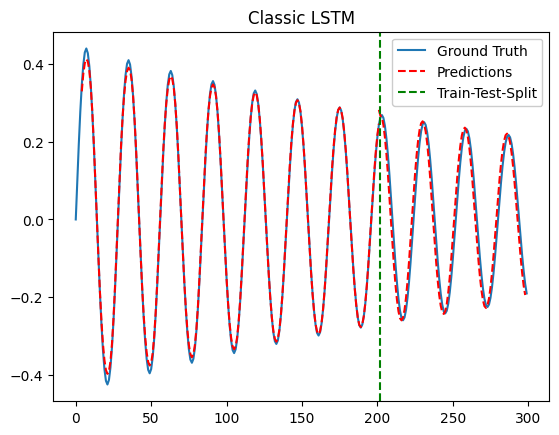

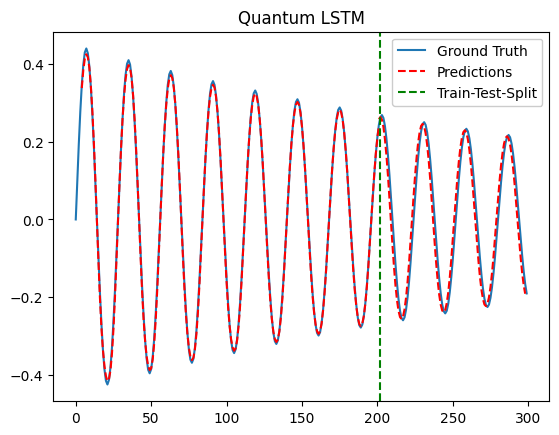

In [46]:
# plot baseline and predictions
plt.plot(data, label="Ground Truth")
plt.plot(train_predict_plot, "r--", label='Predictions')
plt.plot(test_predict_plot, "r--")
# plot line to show train-test-split
plt.axvline(x=TIME_SEQUENCE+len(pred_train), color='g', linestyle='--', label="Train-Test-Split")
plt.legend(framealpha=1, frameon=True)
plt.title("Classic LSTM")
plt.show()


# plot baseline and predictions
plt.plot(data, label="Ground Truth")
plt.plot(train_predict_plot_q, "r--", label='Predictions')
plt.plot(test_predict_plot_q, "r--")
# plot line to show train-test-split
plt.axvline(x=TIME_SEQUENCE+len(pred_train), color='g', linestyle='--', label="Train-Test-Split")
plt.legend(framealpha=1, frameon=True)
plt.title("Quantum LSTM")
plt.show()

### 6.2 Architecture

Quantum Code: 
```python
for sample_x in X: 
    v_t = torch.cat([sample_x, h_t], dim=0)
    v_t_input = self.input_layer(v_t.reshape(1, -1)).reshape(-1)
    # QNN layer
    f_t = torch.sigmoid(self.qnn_layer["1"](v_t_input))
    i_t = torch.sigmoid(self.qnn_layer["2"](v_t_input))
    c_tilde = torch.tanh(self.qnn_layer["3"](v_t_input))
    c_t = f_t * c_t + i_t * c_tilde
    o_t = torch.sigmoid(self.qnn_layer["4"](v_t_input))
    h_t = self.qnn_layer["5"]((self.input_layer_2(o_t * torch.tanh(c_t))))
    outputs.append(h_t.unsqueeze(0))
```

<br>

Classic Code:
```python
for sample_x in X:
    # compute the gates 
    f_t = torch.sigmoid(sample_x @ self.U_f + h_t @ self.V_f + self.b_f)
    i_t = torch.sigmoid(sample_x @ self.U_i + h_t @ self.V_i + self.b_i)
    g_t = torch.tanh(sample_x @ self.U_c + h_t @ self.V_c + self.b_c)
    o_t = torch.sigmoid(sample_x @ self.U_o + h_t @ self.V_o + self.b_o)     
    c_t = f_t * c_t + i_t * g_t
    h_t = o_t * torch.tanh(c_t)
    outputs.append(h_t.unsqueeze(0))
```

The structure is nearly the same, we can see the similarity in the code.

The difference is that the classical LSTM multiples the input with weight matrices and the quantum LSTM uses a quantum circuit to compute the output.
